# Fitting mGPLVM to data from the fly central complex

In this short notebook, we apply mGPLVM to recordings of the fly central complex.

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim

import mgplvm as mgp

torch.manual_seed(1)
np.random.seed(0)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
np.random.seed(14042010)
torch.manual_seed(14042010)

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

loading


In [2]:
!mkdir -p data
!wget --no-check-certificate 'https://raw.githubusercontent.com/tachukao/mgplvm-pytorch/master/examples/fly/fly_data.tsv' -O data/fly_data.tsv

--2022-03-18 15:55:19--  https://raw.githubusercontent.com/tachukao/mgplvm-pytorch/master/examples/fly/fly_data.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156255 (153K) [text/plain]
Saving to: ‘data/fly_data.tsv’

data/fly_data.tsv   100%[===================>] 152.59K  --.-KB/s    in 0.01s   

2022-03-18 15:55:19 (11.4 MB/s) - ‘data/fly_data.tsv’ saved [156255/156255]



In [3]:
with open('data/fly_data.tsv', newline='') as csvfile:
    fly_data = np.array(list(csv.reader(csvfile, delimiter='\t')))

In [4]:
Y = np.expand_dims(fly_data, 2).astype(float).transpose((2, 0, 1))
n_samples, n, m = Y.shape

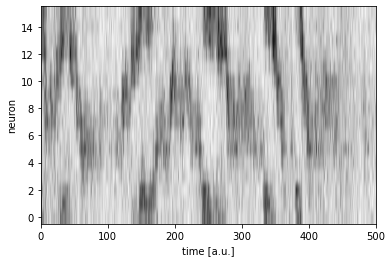

In [5]:
plt.figure()
Yplot = Y[0, :, :]
plt.imshow(Yplot, cmap='Greys', aspect='auto', origin = 'upper')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,500)
plt.ylim(-0.5,n-0.5)
plt.show()
plt.close()

In [6]:
d = 1  # dims of latent space
n_z = 15  # number of inducing points
n_samples = 1  # number of samples

In [7]:
def build_model():
    # specify manifold, kernel and rdist
    manif = mgp.manifolds.Torus(m, d)  # latent distribution manifold
    lat_dist = mgp.rdist.ReLie(manif, m, n_samples)  # construct ReLie distribution
    # Note: we construct the kernel and likelihood by passing the data in for initialization
    kernel = mgp.kernels.QuadExp(
        n, manif.distance
    )  # Use an exponential quadratic (RBF) kernel
    lik = mgp.likelihoods.Gaussian(n)  # Gaussian likelihood
    lprior = mgp.lpriors.Uniform(manif)  # Prior on the manifold distribution
    z = manif.inducing_points(n, n_z)  # build inducing points
    model = mgp.models.SvgpLvm(
        n, m, n_samples, z, kernel, lik, lat_dist, lprior, whiten=True
    ).to(device)
    return model

In [8]:
data = torch.tensor(Y, device=device, dtype=torch.get_default_dtype())
model = build_model()

train_opts = {
    "lrate": 5e-2,
    "max_steps": 1000,
    "n_mc": 64,
    "print_every": 100,
    "burnin": 30 / 5e-2,
    "optimizer": optim.Adam,
}

# train model
progress = mgp.optimisers.svgp.fit(data, model, **train_opts)

iter   0 | elbo -4.772 | kl  0.007 | loss  4.772 | |mu| 0.111 | sig 1.500 | scale 1.000 | ell 2.000 | lik_sig 1.000 |
iter 100 | elbo -0.954 | kl  0.010 | loss  0.956 | |mu| 0.742 | sig 1.362 | scale 0.994 | ell 2.026 | lik_sig 0.942 |
iter 200 | elbo -0.554 | kl  0.021 | loss  0.560 | |mu| 0.816 | sig 1.095 | scale 0.987 | ell 2.040 | lik_sig 0.607 |
iter 300 | elbo  0.037 | kl  0.061 | loss -0.013 | |mu| 1.040 | sig 0.579 | scale 0.955 | ell 2.161 | lik_sig 0.248 |
iter 400 | elbo  0.320 | kl  0.118 | loss -0.263 | |mu| 1.331 | sig 0.230 | scale 0.927 | ell 2.178 | lik_sig 0.174 |
iter 500 | elbo  0.407 | kl  0.151 | loss -0.322 | |mu| 1.438 | sig 0.135 | scale 0.911 | ell 2.040 | lik_sig 0.156 |
iter 600 | elbo  0.425 | kl  0.163 | loss -0.322 | |mu| 1.492 | sig 0.116 | scale 0.896 | ell 1.955 | lik_sig 0.153 |
iter 700 | elbo  0.432 | kl  0.165 | loss -0.319 | |mu| 1.546 | sig 0.111 | scale 0.883 | ell 1.876 | lik_sig 0.152 |
iter 800 | elbo  0.425 | kl  0.161 | loss -0.307 | |mu| 

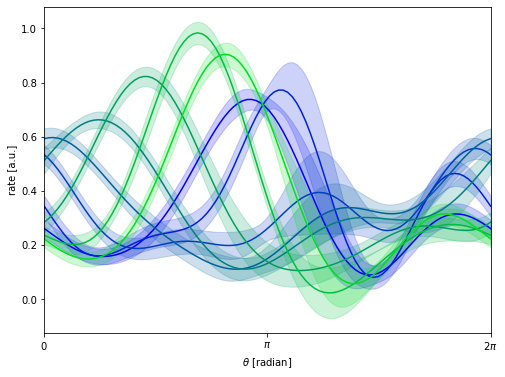

In [9]:
#%% plot tuning curves
query = torch.tensor(np.linspace(0, 2 * np.pi, 100),
                     dtype=torch.get_default_dtype(),
                     device=device)[None, None, ...]
data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
fmean, fvar = model.obs.predict(query, full_cov=False)
fstd = fvar.sqrt()

plt.figure(figsize=(8, 6))
for i in range(0, 16, 2):
    xs = query.cpu().numpy()
    m, std = [arr.cpu().detach().numpy() for arr in [fmean, fstd]]
    xs = xs[0, 0, :]
    m = m[0, i, :]
    std = std[0, i, :]
    col = [0, i/16, 1-i/16]
    plt.plot(xs, m, "-", color = col)
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color=col, alpha=0.2)

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.xticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()
plt.close()

Remember to cite the original authors of the dataset if you use the fly dataset for any further research:

- Turner-Evans et al. (2020), Neuron
- Daniel, Turner-Evans (2020), Kir.zip. Janelia Research Campus ([link to dataset](https://doi.org/10.25378/janelia.12490325.v1))

The data used in this notebook `fly_data.tsv` is extracted from Kir control line 1, fly 1, light epoch, subsampled by a factor of 2.